In [37]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np
from time import time

import glob
import itertools

from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from M1_util_train_test import load_model, test
import mnl

from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo, train_test_split
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
model_type = 'SAE'
load_model_name = 'Autoencoder'
load_model_file = 'sae'
model_code = 'M1_A2'
zoomlevel = 'zoom13_bilateral'
output_dim = 1
model_run_date = '220115'

variable_names = ['active','auto','mas','pt', 'trpgen']


# Load Model Embeddings

In [104]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [105]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Demographics

In [5]:
# demographic variables

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

demo_cs, demo_np = load_demo(data_dir)
demo = np.hstack((np.array(demo_cs).reshape(-1,1), demo_np))
demo = pd.DataFrame(demo, columns = ['geoid'] + demo_variables)
demo_split = train_test_split(demo)

demo_train = demo_split[~demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)
demo_test = demo_split[demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)


# Load Trip Behavior

In [6]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, unique_ct)

train_test_index = df_pivot['train_test'].astype(bool).to_numpy()

y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index,:4]
y_test = y[train_test_index,:4]

In [106]:
embedding_train = aggregate_embeddings[~train_test_index, :]
embedding_test = aggregate_embeddings[train_test_index, :]

In [107]:
x_train = np.concatenate([demo_train, embedding_train], axis=1)
x_test = np.concatenate([demo_test, embedding_test], axis=1)

# MNL for Mode Share

In [108]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=True)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [109]:
wd_list = [0.00005,0.0001,0.0005,0.001,0.005,0.01]
lr_list = [0.005, 0.01, 0.02]

for (lr, wd) in itertools.product(lr_list, wd_list):
    
    # model setup
    model = mnl.MNL2(n_alts=4, dim_embed=2048*output_dim*output_dim, dim_demo=len(demo_variables))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    # model training
    ref1 = 0
    ref2 = 0

    for epoch in range(500):

        kl_ = 0
        mse_ = 0
        mse1_ = 0
        mse2_ = 0
        mse3_ = 0
        mse4_ = 0

        for batch, (x_batch, y_batch) in enumerate(trainloader):
            # Compute prediction and loss
            util = model(x_batch)
            probs = torch.log(nn.functional.softmax(util, dim=1))
            kl = kldivloss(probs, y_batch)
    #         kl = kldivloss(torch.log(util), y_batch)
            kl_ += kl.item()

            mse = mseloss(torch.exp(probs), y_batch)
    #         mse = mseloss(util, y_batch)
            mse_ += mse.sum().item()
            mse1_ += mse[:,0].sum().item()
            mse2_ += mse[:,1].sum().item()
            mse3_ += mse[:,2].sum().item()
            mse4_ += mse[:,3].sum().item()
            mse = mse.sum()

            # Backpropagation
            optimizer.zero_grad()
            kl.backward()
            optimizer.step()
           

        train_kl = kl_/len(trainset)
        train_mse = np.sqrt(mse_/len(trainset))
        train_mse1 = np.sqrt(mse1_/len(trainset))
        train_mse2 = np.sqrt(mse2_/len(trainset))
        train_mse3 = np.sqrt(mse3_/len(trainset))
        train_mse4 = np.sqrt(mse4_/len(trainset))

        if epoch % 10 == 0:
            print(f"[epoch: {epoch:>2d}] Train KL loss: {train_kl:.3f} \
                RMSE {train_mse:.3f} \
                {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
        loss_ = train_kl

        if epoch % 5 == 0:
            if epoch > 50:
                if (np.abs(loss_ - ref1)/ref1<ref1*0.01) & (np.abs(loss_ - ref2)/ref2<ref2*0.01):
                    print("Early stopping at epoch", epoch)
                    break
                if (ref1 < loss_) & (ref1 < ref2):
                    print("Diverging. stop.")
                    break
                if loss_ < best:
                    best = loss_
                    best_epoch = epoch
            else:
                best = loss_
                best_epoch = epoch

            ref2 = ref1
            ref1 = loss_

        if epoch % 10 == 0:

            kl_ = 0
            mse_ = 0 
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(testloader):
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util,dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()

            test_kl = kl_/len(testset)
            test_mse = np.sqrt(mse_/len(testset))
            test_mse1 = np.sqrt(mse1_/len(testset))
            test_mse2 = np.sqrt(mse2_/len(testset))
            test_mse3 = np.sqrt(mse3_/len(testset))
            test_mse4 = np.sqrt(mse4_/len(testset))

            r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
            r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
            r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
            r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

            print(f"[epoch: {epoch:>2d}] Test KL loss: {kl_/len(testset):.3f}\
                    RMSE {np.sqrt(mse_/len(testset)):.3f} \
                    {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
            print(f"\t\t\t\t\t\t\tR2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")


    with open(out_dir+model_code+"_mode_choice.csv", "a") as f:
        f.write("%s,%s,%s,%s,%.4f,%.5f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
            (model_run_date, model_type, zoomlevel, "MNL", lr, wd, 
              train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
              test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
              r1, r2, r3, r4))

[epoch:  0] Train KL loss: 0.596                 RMSE 0.569                 0.208 0.472 0.199 0.133
[epoch:  0] Test KL loss: 0.264                    RMSE 0.336                     0.182 0.256 0.064 0.103
							R2 score: -0.050 -0.053 -2.029 -0.059 
[epoch: 10] Train KL loss: 0.114                 RMSE 0.197                 0.117 0.139 0.054 0.054
[epoch: 10] Test KL loss: 0.209                    RMSE 0.296                     0.166 0.222 0.038 0.096
							R2 score: 0.126 0.204 -0.074 0.093 
[epoch: 20] Train KL loss: 0.100                 RMSE 0.182                 0.107 0.128 0.052 0.051
[epoch: 20] Test KL loss: 0.185                    RMSE 0.281                     0.160 0.209 0.037 0.091
							R2 score: 0.185 0.296 -0.021 0.188 
[epoch: 30] Train KL loss: 0.094                 RMSE 0.173                 0.100 0.121 0.051 0.050
[epoch: 30] Test KL loss: 0.184                    RMSE 0.278                     0.160 0.206 0.038 0.091
							R2 score: 0.190 0.317 -0.035 0.184 
[

[epoch: 10] Train KL loss: 0.125                 RMSE 0.205                 0.118 0.146 0.061 0.055
[epoch: 10] Test KL loss: 0.150                    RMSE 0.244                     0.138 0.177 0.042 0.086
							R2 score: 0.394 0.493 -0.285 0.273 
[epoch: 20] Train KL loss: 0.102                 RMSE 0.183                 0.108 0.129 0.052 0.051
[epoch: 20] Test KL loss: 0.155                    RMSE 0.254                     0.143 0.187 0.038 0.087
							R2 score: 0.345 0.434 -0.026 0.256 
[epoch: 30] Train KL loss: 0.091                 RMSE 0.168                 0.096 0.117 0.052 0.049
[epoch: 30] Test KL loss: 0.162                    RMSE 0.257                     0.145 0.189 0.038 0.088
							R2 score: 0.328 0.424 -0.032 0.231 
[epoch: 40] Train KL loss: 0.085                 RMSE 0.160                 0.091 0.111 0.051 0.047
[epoch: 40] Test KL loss: 0.159                    RMSE 0.251                     0.146 0.182 0.039 0.085
							R2 score: 0.324 0.464 -0.120 0.290 
[epo

[epoch: 70] Train KL loss: 0.076                 RMSE 0.148                 0.085 0.102 0.049 0.043
[epoch: 70] Test KL loss: 0.173                    RMSE 0.256                     0.153 0.180 0.044 0.089
							R2 score: 0.256 0.477 -0.403 0.222 
Diverging. stop.
[epoch:  0] Train KL loss: 0.501                 RMSE 0.515                 0.202 0.428 0.137 0.151
[epoch:  0] Test KL loss: 0.361                    RMSE 0.382                     0.200 0.302 0.048 0.111
							R2 score: -0.273 -0.470 -0.675 -0.215 
[epoch: 10] Train KL loss: 0.109                 RMSE 0.194                 0.114 0.138 0.052 0.054
[epoch: 10] Test KL loss: 0.151                    RMSE 0.250                     0.144 0.183 0.037 0.082
							R2 score: 0.341 0.458 -0.023 0.328 
[epoch: 20] Train KL loss: 0.093                 RMSE 0.172                 0.099 0.122 0.051 0.051
[epoch: 20] Test KL loss: 0.169                    RMSE 0.264                     0.155 0.193 0.040 0.084
							R2 score: 0.233 0.40

[epoch: 50] Train KL loss: 0.074                 RMSE 0.143                 0.082 0.097 0.048 0.045
[epoch: 50] Test KL loss: 0.204                    RMSE 0.288                     0.166 0.212 0.041 0.094
							R2 score: 0.124 0.278 -0.221 0.133 
[epoch: 60] Train KL loss: 0.078                 RMSE 0.151                 0.085 0.104 0.049 0.048
Diverging. stop.
[epoch:  0] Train KL loss: 0.436                 RMSE 0.461                 0.190 0.373 0.141 0.132
[epoch:  0] Test KL loss: 0.233                    RMSE 0.319                     0.171 0.245 0.053 0.098
							R2 score: 0.066 0.034 -1.029 0.040 
[epoch: 10] Train KL loss: 0.102                 RMSE 0.183                 0.107 0.128 0.052 0.051
[epoch: 10] Test KL loss: 0.199                    RMSE 0.288                     0.165 0.213 0.040 0.092
							R2 score: 0.131 0.270 -0.196 0.155 
[epoch: 20] Train KL loss: 0.088                 RMSE 0.163                 0.094 0.113 0.050 0.049
[epoch: 20] Test KL loss: 0.179     

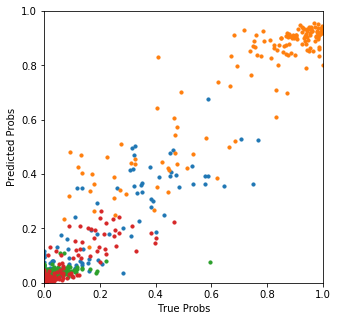

In [31]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    ax.scatter(y_batch.detach().numpy()[:,i], torch.exp(probs).detach().numpy()[:,i], s=10)

ax.set_xlabel("True Probs")
ax.set_ylabel("Predicted Probs")
ax.set_xlim([0,1])
ax.set_ylim([0,1]);


# LR for trip generation

In [73]:
trpgen_train =  y[~train_test_index,1]
trpgen_test =  y[train_test_index,1]

In [110]:
# dataloader and model definition

trainset2 = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(trpgen_train, dtype=torch.float))
trainloader2 = DataLoader(trainset2, batch_size=256, shuffle=True)

testset2 = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(trpgen_test, dtype=torch.float))
testloader2 = DataLoader(testset2, batch_size=len(testset), shuffle=True)

mseloss = nn.MSELoss(reduction='mean')

In [111]:
wd_list = [0.00005,0.0001,0.0005,0.001,0.005,0.01]
lr_list = [0.005, 0.01, 0.02]

for (lr, wd) in itertools.product(lr_list, wd_list):
    
    # model setup
    model = mnl.MNL2(n_alts=1, dim_embed=2048*output_dim*output_dim, dim_demo=len(demo_variables))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    # model training
    ref1 = 0
    ref2 = 0

    for epoch in range(500):

        mse_ = 0

        for batch, (x_batch, y_batch) in enumerate(trainloader2):
            # Compute prediction and loss
            pred = model(x_batch)
            pred = F.relu(pred).squeeze()

            mse = mseloss(pred, y_batch)
            mse_ += mse.item()

            # Backpropagation
            optimizer.zero_grad()
            mse.backward()
            optimizer.step()
           

        train_r = r2_score(y_batch.numpy(), pred.detach().numpy())
        train_rmse = np.sqrt(mse_/len(trainset2))
        
        if epoch % 10 == 0:
            print(f"[epoch: {epoch:>2d}] Train RMSE : {train_rmse:.3f} R2 score: {train_r:.3f} ")
        loss_ = train_mse

        if epoch % 5 == 0:
            if epoch > 50:
                if (np.abs(loss_ - ref1)/ref1<ref1*0.01) & (np.abs(loss_ - ref2)/ref2<ref2*0.01):
                    print("Early stopping at epoch", epoch)
                    break
                if (ref1 < loss_) & (ref1 < ref2):
                    print("Diverging. stop.")
                    break
                if loss_ < best:
                    best = loss_
                    best_epoch = epoch
            else:
                best = loss_
                best_epoch = epoch

            ref2 = ref1
            ref1 = loss_

        if epoch % 10 == 0:

            mse_ = 0 

            for batch, (x_batch, y_batch) in enumerate(testloader2):
                pred = model(x_batch)
                pred = F.relu(pred).squeeze()

                mse = mseloss(pred, y_batch)
                mse_ += mse.item()
            
            test_rmse = np.sqrt(mse_/len(testset2))
            test_r = r2_score(y_batch.numpy(),pred.detach().numpy())
            
            print(f"[epoch: {epoch:>2d}] Test RMSE {test_rmse:.3f} R2 score: {test_r:.3f} ")


    with open(out_dir+model_code+"_regression_trpgen.csv", "a") as f:
        f.write("%s,%s,%s,%s,%.4f,%.5f,%.4f,%.4f,%.4f,%.4f\n" % \
            (model_run_date, model_type, zoomlevel, "MNL", lr, wd, 
              train_rmse, train_r, test_rmse, test_r))

[epoch:  0] Train RMSE : 0.029 R2 score: -1.882 
[epoch:  0] Test RMSE 0.036 R2 score: -0.665 
[epoch: 10] Train RMSE : 0.010 R2 score: 0.614 
[epoch: 10] Test RMSE 0.021 R2 score: 0.444 
[epoch: 20] Train RMSE : 0.009 R2 score: 0.716 
[epoch: 20] Test RMSE 0.022 R2 score: 0.409 
[epoch: 30] Train RMSE : 0.008 R2 score: 0.788 
[epoch: 30] Test RMSE 0.022 R2 score: 0.404 
[epoch: 40] Train RMSE : 0.008 R2 score: 0.730 
[epoch: 40] Test RMSE 0.022 R2 score: 0.369 
[epoch: 50] Train RMSE : 0.007 R2 score: 0.807 
[epoch: 50] Test RMSE 0.022 R2 score: 0.401 
Early stopping at epoch 55
[epoch:  0] Train RMSE : 0.048 R2 score: -4.500 
[epoch:  0] Test RMSE 0.028 R2 score: -0.013 
[epoch: 10] Train RMSE : 0.010 R2 score: 0.629 
[epoch: 10] Test RMSE 0.021 R2 score: 0.432 
[epoch: 20] Train RMSE : 0.008 R2 score: 0.814 
[epoch: 20] Test RMSE 0.021 R2 score: 0.450 
[epoch: 30] Train RMSE : 0.008 R2 score: 0.768 
[epoch: 30] Test RMSE 0.021 R2 score: 0.453 
[epoch: 40] Train RMSE : 0.008 R2 score

[epoch: 10] Train RMSE : 0.009 R2 score: 0.690 
[epoch: 10] Test RMSE 0.020 R2 score: 0.468 
[epoch: 20] Train RMSE : 0.008 R2 score: 0.719 
[epoch: 20] Test RMSE 0.020 R2 score: 0.475 
[epoch: 30] Train RMSE : 0.010 R2 score: 0.650 
[epoch: 30] Test RMSE 0.021 R2 score: 0.460 
[epoch: 40] Train RMSE : 0.008 R2 score: 0.782 
[epoch: 40] Test RMSE 0.018 R2 score: 0.572 
[epoch: 50] Train RMSE : 0.008 R2 score: 0.847 
[epoch: 50] Test RMSE 0.021 R2 score: 0.445 
Early stopping at epoch 55
[epoch:  0] Train RMSE : 0.057 R2 score: -8.721 
[epoch:  0] Test RMSE 0.086 R2 score: -8.409 
[epoch: 10] Train RMSE : 0.010 R2 score: 0.552 
[epoch: 10] Test RMSE 0.023 R2 score: 0.348 
[epoch: 20] Train RMSE : 0.010 R2 score: 0.681 
[epoch: 20] Test RMSE 0.024 R2 score: 0.259 
[epoch: 30] Train RMSE : 0.009 R2 score: 0.779 
[epoch: 30] Test RMSE 0.020 R2 score: 0.490 
[epoch: 40] Train RMSE : 0.009 R2 score: 0.747 
[epoch: 40] Test RMSE 0.020 R2 score: 0.498 
[epoch: 50] Train RMSE : 0.008 R2 score: 